<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/LLM_Court.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import matplotlib.pyplot as plt
import torch
import joblib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import time
import re
import openai
import json
from sklearn.model_selection import train_test_split
import ast

In [4]:

drive.mount('/content/drive')


Mounted at /content/drive


In [5]:

folder_id = "בית המשפט - קבצים שנבדקו"
directory_path = f"/content/drive/My Drive/{folder_id}"
classifiers_path = "/content/drive/MyDrive/בית המשפט - מסווגים/"

if not os.path.exists(directory_path):
    print(f"Directory {directory_path} does not exist. Please check the folder path.")
else:
    dataframes = []

    for file_name in os.listdir(directory_path):
        if file_name.endswith(".xlsx") or file_name.endswith(".xls"):
            file_path = os.path.join(directory_path, file_name)
            try:
                df = pd.read_excel(file_path)
                dataframes.append(df)
            except Exception as e:
                print(f"Failed to read {file_name}: {e}")

    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
        print("All Excel files have been concatenated successfully!")

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


All Excel files have been concatenated successfully!


In [6]:
full_ra_rap = pd.read_excel("/content/drive/My Drive/full_ra_rap.xlsx")

In [26]:
check_gender_bias = pd.concat([dataframes[0], dataframes[1], dataframes[2]])
check_gender_bias = pd.merge(full_ra_rap, check_gender_bias, on='מספר הליך', how='right')
check_gender_bias.drop_duplicates(subset = 'מספר הליך',inplace = True)
check_gender_bias.dropna(subset = ["בקשה לרשות ערעור התקבלה?"],inplace=True)

In [27]:
for col in check_gender_bias.columns:
    if(col.find("מגדר")!=-1 or col.find("ערעור")!=-1):
      print(col)

מגדר
בקשה לרשות ערעור התקבלה?
הערעור התקבל?
הערות תוצאת ערעור
prediction_adjusted_threshold
בקשת רשות ערעור התקבלה?
prediction_second_model_adjusted
ערעור התקבל?


In [28]:
check_gender_bias[["בקשה לרשות ערעור התקבלה?","מגדר"]]

,בקשה לרשות ערעור התקבלה?,מגדר
0,נדחה,['זכר']
1,נדחה,['זכר']
3,התקבל,"['זכר', 'זכר', 'זכר']"
5,נדחה,['זכר']
6,נדחה,['זכר']
...,...,...
5455,נדחה,['זכר']
5474,נדחה,['זכר']
5592,נדחה,['זכר']
5606,נדחה,['זכר']


<Figure size 800x500 with 0 Axes>

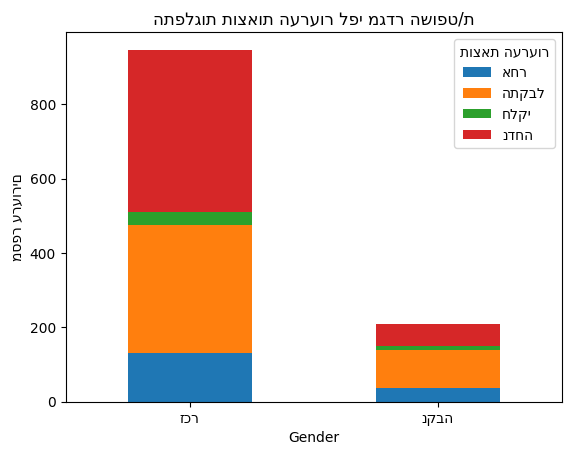

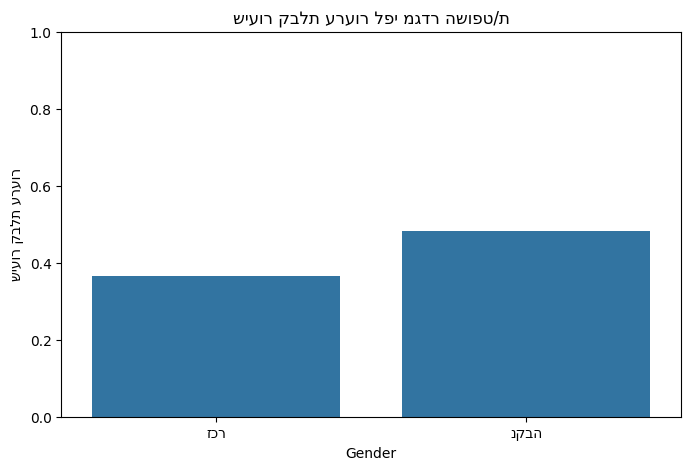

Appeal Outcome  אחר  התקבל  חלקי  נדחה  Total  Acceptance Rate
Gender                                                        
זכר             130    346    34   437    947         0.365364
נקבה             38    101    11    59    209         0.483254


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval


# המרת המחרוזת ברשימת מגדרים למבנה רשימה
check_gender_bias["מגדר"] = check_gender_bias["מגדר"].apply(literal_eval)  # ממיר טקסט לרשימה

# פונקציה להשטחת הנתונים – כל שופט יקבל שורה משלו
def expand_genders(df):
    expanded_data = []
    for _, row in df.iterrows():
        for gender in row["מגדר"]:
            expanded_data.append({"Gender": gender, "Appeal Outcome": row["בקשה לרשות ערעור התקבלה?"]})
    return pd.DataFrame(expanded_data)

# הרחבת הטבלה
df_expanded = expand_genders(check_gender_bias)

# ספירת תוצאות הערעור לפי מגדר
outcome_counts = df_expanded.groupby(["Gender", "Appeal Outcome"]).size().unstack().fillna(0)

# יצירת גרף התפלגות תוצאות לפי מגדר
plt.figure(figsize=(8, 5))
outcome_counts.plot(kind="bar", stacked=True)
plt.ylabel("מספר ערעורים")
plt.title("התפלגות תוצאות הערעור לפי מגדר השופט/ת")
plt.xticks(rotation=0)
plt.legend(title="תוצאת הערעור")
plt.show()

# חישוב יחס קבלת ערעור לכל מגדר
outcome_counts["Total"] = outcome_counts.sum(axis=1)
outcome_counts["Acceptance Rate"] = outcome_counts.get("התקבל", 0) / outcome_counts["Total"]

# יצירת גרף של אחוזי קבלת ערעור לפי מגדר
plt.figure(figsize=(8, 5))
sns.barplot(x=outcome_counts.index, y=outcome_counts["Acceptance Rate"])
plt.ylabel("שיעור קבלת ערעור")
plt.title("שיעור קבלת ערעור לפי מגדר השופט/ת")
plt.ylim(0, 1)
plt.show()

# הצגת הטבלה עם התוצאות
print(outcome_counts)


'זכר'

# Bias - number of Judges

<Figure size 800x500 with 0 Axes>

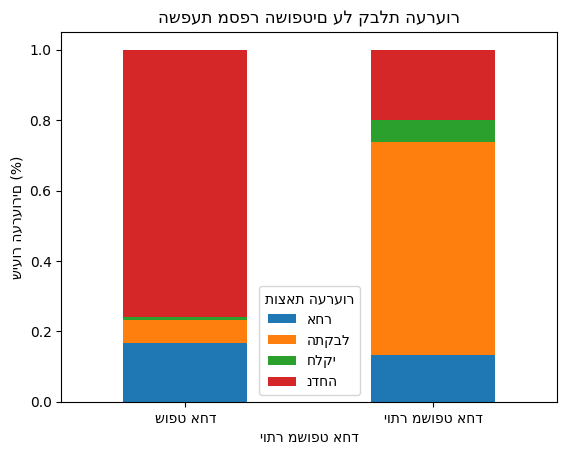

שיעור קבלת הערעור לפי מספר שופטים:
יותר משופט אחד
False    0.065126
True     0.606195
Name: התקבל, dtype: float64


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

# טעינת הנתונים
df = check_gender_bias.copy()

# חישוב מספר השופטים בכל תיק
df["מספר שופטים"] = df["מגדר"].apply(len)

# חלוקת המקרים לשתי קבוצות: שופט יחיד או יותר מאחד
df["יותר משופט אחד"] = df["מספר שופטים"] > 1

# ספירת המקרים לפי מספר השופטים והאם הערעור התקבל
outcome_counts = df.groupby("יותר משופט אחד")["בקשה לרשות ערעור התקבלה?"].value_counts(normalize=True).unstack()

# יצירת גרף
plt.figure(figsize=(8, 5))
outcome_counts.plot(kind="bar", stacked=True)
plt.ylabel("שיעור הערעורים (%)")
plt.title("השפעת מספר השופטים על קבלת הערעור")
plt.xticks([0, 1], ["שופט אחד", "יותר משופט אחד"], rotation=0)
plt.legend(title="תוצאת הערעור")
plt.show()

# חישוב אחוז קבלת ערעור לפי מספר השופטים
acceptance_rate = outcome_counts.get("התקבל", 0)

# הדפסת סטטיסטיקה
print("שיעור קבלת הערעור לפי מספר שופטים:")
print(acceptance_rate)


In [99]:
len(dataframes)

6

In [100]:
df_1 = dataframes[0].copy()

df_1.columns

Index(['level_0', 'index', 'גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך', 'predicted_probability',
       'prediction_original_model', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'קידוד', 'קידוד חוזר', 'הערות ',
       'הערות קידוד חוזר'],
      dtype='object')

In [101]:
df_1 = df_1[['גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך',  'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות ',
       'הערות קידוד חוזר']]

In [102]:
df_2 = dataframes[1].copy()

In [103]:
df_2 = df_2[['גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך',
       'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערעור התקבל?', 'רע"פ בקשה אחרת או דלמטה מיוחד',
       'הערות תוצאת ערעור', 'הערות ', 'הערות קידוד חוזר']]

In [104]:
df = pd.concat([df_1, df_2], ignore_index=True)

In [105]:
df_3 = dataframes[2].copy()

In [106]:
df_3 = df_3[['גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך',
       'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערעור התקבל?', 'הערות תוצאת ערעור', 'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות ']]

In [107]:
df = pd.concat([df, df_3], ignore_index=True)

In [108]:
columns_to_check = [
    "הערות ",
    "הערות תוצאת ערעור",
    "הערות קידוד חוזר",
    "טקסט שמצביע על תוצאת בקשה שונה",
    "טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)",
    "טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)"
]


df = df[~df[columns_to_check].isna().all(axis=1)]

In [109]:
df.shape

(348, 13)

Index(['level_0', 'index', 'גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך', 'predicted_probability',
       'prediction_original_model', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'קידוד', 'קידוד חוזר', 'הערות ',
       'הערות קידוד חוזר', 'prediction_custom_threshold',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערות תוצאת ערעור',
       'prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?',
       'גוף המסמך חתוך מסווג שני', 'prediction_second_model',
       'second_model_predicted_probability',
       'prediction_second_model_adjusted\nערעור התקבל?'],
      dtype='object')

Index(['level_0', 'index', 'גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך', 'predicted_probability',
       'prediction_original_model', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'קידוד', 'קידוד חוזר', 'הערות ',
       'הערות קידוד חוזר', 'prediction_custom_threshold',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערות תוצאת ערעור',
       'prediction_adjusted_threshold\nבקשת רשות ערעור התקבלה?',
       'גוף המסמך חתוך מסווג שני', 'prediction_second_model',
       'second_model_predicted_probability',
       'prediction_second_model_adjusted\nערעור התקבל?'],
      dtype='object')

In [73]:
len(df["גוף המסמך"])

df["length"] = df["גוף המסמך"].apply(lambda x: len(str(x).split()))

average_length = df["length"].mean()
max_length = df["length"].max()
min_length = df["length"].min()

print(f"אורך ממוצע של פסקי דין: {average_length:.2f} מילים")
print(f"פסק הדין הארוך ביותר מכיל {max_length} מילים")
print(f"פסק הדין הקצר ביותר מכיל {min_length} מילים")


אורך ממוצע של פסקי דין: 722.41 מילים
פסק הדין הארוך ביותר מכיל 5920 מילים
פסק הדין הקצר ביותר מכיל 60 מילים


In [74]:
def convert_list_to_string(text):
    if isinstance(text, str) and text.startswith("[") and text.endswith("]"):
        try:
            text_list = ast.literal_eval(text)
            return ' '.join(text_list)
        except (ValueError, SyntaxError):
            return text
    return text

def clean_text(text):
    if isinstance(text, list):
        text = ' '.join(text)
    elif isinstance(text, str):
        text = re.sub(r'\n+', ' ', text)  # הסרת שורות חדשות מרובות
        text = re.sub(r'\n', '', text)   # הסרת תווי newline \n מהטקסט
        text = re.sub(r'\xa0', ' ', text)  # הסרת תווי \xa0 מהטקסט
        text = re.sub(r'\s+', ' ', text)  # הסרת רווחים מרובים

        text = re.sub(r"העותק כפוף לשינויי עריכה וניסוח.*?$", "", text, flags=re.MULTILINE)
        text = re.sub(r"מרכז מידע, טל' \d{2,3}-\d{6,7}.*?$", "", text, flags=re.MULTILINE)
        text = re.sub(r"אתר אינטרנט, .*?$", "", text, flags=re.MULTILINE)
    return text

print("שורות לא קריאות לפני המרה:")
print(df["גוף המסמך"].head())

df["גוף המסמך"] = df["גוף המסמך"].apply(clean_text)

print("\nשורות לאחר המרה:")
print(df["גוף המסמך"].head())

file_path_full = 'checked_df_cleaned.csv' # FULL RAP DATA CLEANED
df.to_csv(file_path_full, index=False, encoding='utf-8')


שורות לא קריאות לפני המרה:
5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [75]:
def extract_relevant_part(text):
    words = str(text).split()
    if len(words) > 1000:
        return " ".join(words[-800:-20])
    return text

df["גוף המסמך חתוך"] = df["גוף המסמך"].apply(extract_relevant_part)

df[["גוף המסמך", "גוף המסמך חתוך"]].head()


גוף המסמך  \
5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    ['החלטה בתיק רע"פ 3622/15 בבית המשפט העליון רע"פ 3622/15 לפני: כבוד השופט ח\' מלצר המבקש: יעקב סארה נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בנצרת (כב\' השופטים: א\' הלמן, י\' שיטרית, ס\' דבור) מתאריך 12.05.2015 ב-ע"פ 28199-03-15 בשם המבקש: עו"ד בוריס קסונוביץ; עו"ד אלפסי ברנרד החלטה 1. לפני בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בנצרת (כב\' השופטים: א\' הלמן, י\' שיטרית, ס\' דבור) ב-ע"פ 28199-03-15, בגדרו התקבל, באופן חלקי, ערעורו של המבקש על גזר דינו של בית המשפט השלום בנצרת (כב\' סגנית הנשיא ל\' יונג-גפר) ב-ת"פ 1687-01-14. לצד בקשת רשות הערעור, הוגשה גם בקשה לעיכוב ביצוע של עונש המאסר שהושת על המבקש. בהקשר זה הוריתי כי עונש המאסר בפועל שהושת על המבקש יעוכב עד למתן החלטה אחרת. אביא עתה את הנתונים הרלבנטיים להכרעה במכלול. רקע והליכים קודמים 2. בית משפט השלום הנכבד הרשיע את המבקש, על פי הודאתו, במסגרת הסדר טיעון – בעבירות אלימות שיוחסו לו בכתב אישום מתוקן שהוגש נגדו ונגד שני נאשמים נוספים (להלן: נאשם 1 ונ

Index(['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות ', 'הערות קידוד חוזר',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערות תוצאת ערעור', 'length'],
      dtype='object')

In [18]:
df = df[['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות ', 'הערות קידוד חוזר',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערות תוצאת ערעור', 'length',]]

In [19]:
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace("\n", "")
df.columns = df.columns.str.replace("  ", " ")

In [20]:
df.rename(columns={
    'הערות ':"הערות",
    'טקסט שמצביע על תוצאת בקשה שונה':"טקסט שמצביע על תוצאת בקשה",
    "טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)": "טקסט שמצביע על התוצאה"
}, inplace=True)

df.columns


Index(['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות', 'הערות קידוד חוזר',
       'טקסט שמצביע על התוצאה', 'הערות תוצאת ערעור', 'length'],
      dtype='object')

In [21]:
columns_to_merge = [
    'טקסט שמצביע על תוצאת בקשה',
    'רע"פ בקשה אחרת או דלמטה מיוחד',  "הערות", 'הערות קידוד חוזר',
    "טקסט שמצביע על התוצאה",
    'הערות תוצאת ערעור'
]

def clean_merge_columns(row, columns):
    values = []
    for col in columns:
        if pd.notna(row[col]) and str(row[col]).strip():
            text = f"{str(row[col]).strip()}"
            text.replace("?", "")
            text
            text = re.sub(r"הערה של \S+\s*", "", text)
            values.append(text)

    return "\n".join(values) if values else None

# יצירת עמודה מאוחדת עם כותרות לכל ערך
df["תוצאה מסכמת"] = df.apply(lambda row: clean_merge_columns(row, columns_to_merge), axis=1)


# הצגת מספר דוגמאות לבדיקה
df[["תוצאה מסכמת"]].head()


,תוצאה מסכמת
5,לנוכח כל האמור לעיל – הבקשה למתן רשות ערעור נדחית
31,בקשה לעיכוב ביצוע עונש מאסר\nבקשה אחרת
67,"אשר על כן, הבקשה לרשות ערעור נדחית בזאת"
73,- זהו פסק דין משלים
114,חזרו בהם באי כוח המבקשים מהבקשות למתן רשות ערע...


In [22]:

for i in range(3):
    print(f"פסק דין {i+1} (תוצאה מסכמת):\n")
    print(df["תוצאה מסכמת"].iloc[i])
    print("="*80)


פסק דין 1 (תוצאה מסכמת):

לנוכח כל האמור לעיל – הבקשה למתן רשות ערעור נדחית
פסק דין 2 (תוצאה מסכמת):

בקשה לעיכוב ביצוע עונש מאסר
בקשה אחרת
פסק דין 3 (תוצאה מסכמת):

אשר על כן, הבקשה לרשות ערעור נדחית בזאת


In [23]:
pd.set_option('display.max_colwidth', None)

df[["גוף המסמך חתוך", "תוצאה מסכמת"]].sample(5, random_state=42)

,גוף המסמך חתוך,תוצאה מסכמת
3004,"['פסק דין בתיק רע""פ 4386/08 בבית המשפט העליון רע""פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע""פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג""נ בשם המבקש: עו""ד דוד גולן בשם המשיבה: עו""ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש בעניינו. ניתן היום, א\' בחשון התשס""ט (30.10.2008). ש ו פ ט ת ש ו פ ט ש ו פ ט _________________________","ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה"
1922,"['החלטה בתיק רע""פ 1682/11 בבית המשפט העליון רע""פ 1682/11 בפני: כבוד השופט ס\' ג\'ובראן המבקש: ואיל מזערה נגד המשיבה: מדינת ישראל בקשה לדחיית מועד תחילת ריצוי עונש המאסר בשם המבקש: עו""ד מאליק מנצור החלטה הבקשה נדחית. ניתנה היום, כ""ה באדר ב התשע""א (31.3.2011). ש ו פ ט _________________________",בקשה אחרת\nבקשה לדחיית מועד תחילת ריצוי עונש המאסר
3096,"['החלטה בתיק בש""פ 1092/17 בבית המשפט העליון רע""פ 1092/17 לפני: כבוד השופטת ד\' ברק-ארז המערערים: 1. כפיר דהן 2. שירה דהן נגד המשיבה: הוועדה המקומית לתכנון ובניה מטה יהודה בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בירושלים מיום 30.1.2017 בע""פ 23940-12-16 שניתן על-ידי כבוד השופט ח\' מ\' לומפ בשם המערערים: בעצמם בשם המשיבה: עו""ד רעות אהרון, עו""ד מאיר בן דוד פסק דין 1. הבקשה שבפני נקלטה במזכירות בית המשפט, בטעות, תחת הסיווג בש""פ. הלכה למעשה, מדובר בבקשת רשות לערער על פסק דינו של בית המשפט המחוזי בירושלים מיום 30.1.2017 (ע""פ 23940-12-16, השופטת ח\' מ\' לומפ). סיווגה הראוי אפוא הוא רע""פ, וכך אני מורה. 2. מקורו של ההליך דנן הוא בבקשה למתן אורכה לביצועו של צו ההריסה שהוצא ביחס למבנה היביל שבו מתגוררים המבקשים במסגרת הליך פלילי לפי חוק התכנון והבניה, התשכ""ה-1965. הבקשה נדחתה על ידי בית המשפט לעניינים מקומיים בבית שמש ועל כן הגישו המבקשים ערעור לבית המשפט המחוזי, אשר קבע כי תינתן למבקשים אורכה לפנות את המבנה עד ליום 1.4.2017 ולהרסו עד ליום 2.5.2017. לאחר מכן המבקשים הגישו בקשת אורכה נוספת לבית המשפט המחוזי, וזו נדחתה. על כך נסבה הבקשה שבפני. 3. בתשובה שהוגשה מטעם המשיבה צוין כי המקרה העומד ביסוד ההליך כרוך בנסיבות אישיות ומשפחתיות חריגות וקשות ועל כן היא מבקשת להותיר את ההכרעה בו לשיקול דעתו של בית המשפט. בהתחשב בכך ולאחר שבחנתי את מכלול הנסיבות העניין, אני מורה על מתן אורכה נוספת למבקשים לפנות את המבנה עד ליום 1.7.2017 ולהרסו עד ליום 2.8.2017 (בתנאים שנקבעו בפסק דינו של בית המשפט המחוזי). 4. הבקשה מתקבלת אפוא כמפורט בפסקה 3. על המבקשים להבין כי ההיענות לבקשתם התאפשרה לנוכח העמדה שגילתה המשיבה, וכי אל להם לצפות לכל הקלות נוספות, אלא להיערך לביצוע הצו השיפוטי, משתמו ההליכים כולם. ניתן היום, \u200fי""ט בשבט התשע""ז (\u200f15.2.2017). ש ו פ ט ת _________________________",ביהמ׳׳ש נתן אורכה אך לא ביטל את צו ההריסה\nהבקשה מתקבלת אפוא כמפורט בפסקה 3
3022,"['פסק דין בתיק רע""פ 1793/09 בבית המשפט העליון רע""פ 1793/09 בפני: כבוד השופט א\' א\' לוי כבוד השופטת ע\' ארבל כבוד השופט י\' דנציגר המבקשים: 1. פאבל מינסטר 2. זאב שוורץ נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של ביתה משפט המחוזי בתל-אביב, בע""פ 70149/08, מיום 28.1.09, שניתן על ידי כבוד ס\' הנשיא השופטת ד\' ברלינר, ס. הנשיא השופט ז\' המר, ס. הנשיא השופטת ב\' אופיר-תום בשם המבקש 1: עו""ד אמיר ציון בשם המבקש 2: עו""ד רובינשטיין מנחם פסק דין נוכח האמור בתגובת המשיבה, ניתנת בזאת רשות ערעור והבקשה תידון כבערעור גופו. עניינם של המבקשים יובא בשנית בפני בית המשפט המחוזי, המתבקש להבהיר אם תוצאת פסק-דינו היא זיכוי מוחלט של המבקשים או זיכוי מחמת הספק. ניתן היום, ט""ו באדר התשס""ט (11.03.09). ש ו פ ט ש ו פ ט ת ש ו פ ט _________________________",ביהמש לא הכריע בערעור והחזיר לדיון נוסף במחוזי
2649,"['בבית המשפט העליון בירושלים רע""פ 9608/01 בפני: כבוד השופט א\' ריבלין המבקשים: 1. גשמי ברכה ה.ש.י.ג.(1995) 2. גשמי ברכה בע""מ 3. ה.ש.י.ג.(1995)יזום פרוייקטים 4. שנהב 

In [24]:
df[["גוף המסמך חתוך", "תוצאה מסכמת"]].sample(5, random_state=42)

,גוף המסמך חתוך,תוצאה מסכמת
3004,"['פסק דין בתיק רע""פ 4386/08 בבית המשפט העליון רע""פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע""פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג""נ בשם המבקש: עו""ד דוד גולן בשם המשיבה: עו""ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש בעניינו. ניתן היום, א\' בחשון התשס""ט (30.10.2008). ש ו פ ט ת ש ו פ ט ש ו פ ט _________________________","ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה"
1922,"['החלטה בתיק רע""פ 1682/11 בבית המשפט העליון רע""פ 1682/11 בפני: כבוד השופט ס\' ג\'ובראן המבקש: ואיל מזערה נגד המשיבה: מדינת ישראל בקשה לדחיית מועד תחילת ריצוי עונש המאסר בשם המבקש: עו""ד מאליק מנצור החלטה הבקשה נדחית. ניתנה היום, כ""ה באדר ב התשע""א (31.3.2011). ש ו פ ט _________________________",בקשה אחרת\nבקשה לדחיית מועד תחילת ריצוי עונש המאסר
3096,"['החלטה בתיק בש""פ 1092/17 בבית המשפט העליון רע""פ 1092/17 לפני: כבוד השופטת ד\' ברק-ארז המערערים: 1. כפיר דהן 2. שירה דהן נגד המשיבה: הוועדה המקומית לתכנון ובניה מטה יהודה בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בירושלים מיום 30.1.2017 בע""פ 23940-12-16 שניתן על-ידי כבוד השופט ח\' מ\' לומפ בשם המערערים: בעצמם בשם המשיבה: עו""ד רעות אהרון, עו""ד מאיר בן דוד פסק דין 1. הבקשה שבפני נקלטה במזכירות בית המשפט, בטעות, תחת הסיווג בש""פ. הלכה למעשה, מדובר בבקשת רשות לערער על פסק דינו של בית המשפט המחוזי בירושלים מיום 30.1.2017 (ע""פ 23940-12-16, השופטת ח\' מ\' לומפ). סיווגה הראוי אפוא הוא רע""פ, וכך אני מורה. 2. מקורו של ההליך דנן הוא בבקשה למתן אורכה לביצועו של צו ההריסה שהוצא ביחס למבנה היביל שבו מתגוררים המבקשים במסגרת הליך פלילי לפי חוק התכנון והבניה, התשכ""ה-1965. הבקשה נדחתה על ידי בית המשפט לעניינים מקומיים בבית שמש ועל כן הגישו המבקשים ערעור לבית המשפט המחוזי, אשר קבע כי תינתן למבקשים אורכה לפנות את המבנה עד ליום 1.4.2017 ולהרסו עד ליום 2.5.2017. לאחר מכן המבקשים הגישו בקשת אורכה נוספת לבית המשפט המחוזי, וזו נדחתה. על כך נסבה הבקשה שבפני. 3. בתשובה שהוגשה מטעם המשיבה צוין כי המקרה העומד ביסוד ההליך כרוך בנסיבות אישיות ומשפחתיות חריגות וקשות ועל כן היא מבקשת להותיר את ההכרעה בו לשיקול דעתו של בית המשפט. בהתחשב בכך ולאחר שבחנתי את מכלול הנסיבות העניין, אני מורה על מתן אורכה נוספת למבקשים לפנות את המבנה עד ליום 1.7.2017 ולהרסו עד ליום 2.8.2017 (בתנאים שנקבעו בפסק דינו של בית המשפט המחוזי). 4. הבקשה מתקבלת אפוא כמפורט בפסקה 3. על המבקשים להבין כי ההיענות לבקשתם התאפשרה לנוכח העמדה שגילתה המשיבה, וכי אל להם לצפות לכל הקלות נוספות, אלא להיערך לביצוע הצו השיפוטי, משתמו ההליכים כולם. ניתן היום, \u200fי""ט בשבט התשע""ז (\u200f15.2.2017). ש ו פ ט ת _________________________",ביהמ׳׳ש נתן אורכה אך לא ביטל את צו ההריסה\nהבקשה מתקבלת אפוא כמפורט בפסקה 3
3022,"['פסק דין בתיק רע""פ 1793/09 בבית המשפט העליון רע""פ 1793/09 בפני: כבוד השופט א\' א\' לוי כבוד השופטת ע\' ארבל כבוד השופט י\' דנציגר המבקשים: 1. פאבל מינסטר 2. זאב שוורץ נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של ביתה משפט המחוזי בתל-אביב, בע""פ 70149/08, מיום 28.1.09, שניתן על ידי כבוד ס\' הנשיא השופטת ד\' ברלינר, ס. הנשיא השופט ז\' המר, ס. הנשיא השופטת ב\' אופיר-תום בשם המבקש 1: עו""ד אמיר ציון בשם המבקש 2: עו""ד רובינשטיין מנחם פסק דין נוכח האמור בתגובת המשיבה, ניתנת בזאת רשות ערעור והבקשה תידון כבערעור גופו. עניינם של המבקשים יובא בשנית בפני בית המשפט המחוזי, המתבקש להבהיר אם תוצאת פסק-דינו היא זיכוי מוחלט של המבקשים או זיכוי מחמת הספק. ניתן היום, ט""ו באדר התשס""ט (11.03.09). ש ו פ ט ש ו פ ט ת ש ו פ ט _________________________",ביהמש לא הכריע בערעור והחזיר לדיון נוסף במחוזי
2649,"['בבית המשפט העליון בירושלים רע""פ 9608/01 בפני: כבוד השופט א\' ריבלין המבקשים: 1. גשמי ברכה ה.ש.י.ג.(1995) 2. גשמי ברכה בע""מ 3. ה.ש.י.ג.(1995)יזום פרוייקטים 4. שנהב 

In [25]:
df.to_excel("/content/dataframe_cleaned.xlsx", index=False)

# split - train, validation, test

In [26]:
train_data, temp_data = train_test_split(df, test_size=0.2, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

def convert_to_jsonl(data, filename):
    with open(filename, "w", encoding="utf-8") as f:
        for _, row in data.iterrows():
            json.dump({
                "messages": [
                    {"role": "system", "content": "אתה עוזר משפטי לניתוח פסקי דין מסוג רע\"פ"},
                    {"role": "user", "content": row["גוף המסמך חתוך"]},
                    {"role": "assistant", "content": row["תוצאה מסכמת"]}
                ]
            }, f, ensure_ascii=False)
            f.write("\n")

convert_to_jsonl(train_data, "train.jsonl")
convert_to_jsonl(valid_data, "valid.jsonl")
convert_to_jsonl(test_data, "test.jsonl")


# Fine tune Llama 2 using LoRA

In [27]:
# from huggingface_hub import login
# from transformers import AutoTokenizer, AutoModelForCausalLM
# import json
# from peft import LoraConfig, get_peft_model, TaskType
# from transformers import TrainingArguments, Trainer

In [28]:
# with open("/content/Llama_login.txt", "r") as file:
#   llama_login = file.read().strip()

# login(llama_login)

# MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"

# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_auth_token=True)
# model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype="auto", device_map="auto", use_auth_token=True)

# print("🎯 המודל נטען בהצלחה!")


In [29]:
# def generate_summary_llama2(case_text):
#     input_ids = tokenizer(case_text, return_tensors="pt").input_ids.to("cuda")
#     output = model.generate(input_ids, max_new_tokens=100)
#     return tokenizer.decode(output[0], skip_special_tokens=True)

# # בודקים פסק דין לדוגמה
# sample_case = dataset["valid"][0]["messages"][1]["content"]
# llama2_summary = generate_summary_llama2(sample_case)

# print(llama2_summary)


In [30]:
# test_text = "פסק דין משפטי לדוגמה על סכסוך אזרחי"
# input_ids = tokenizer(test_text, return_tensors="pt").input_ids.to("cuda")

# output = model.generate(input_ids, max_new_tokens=100)
# generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

# print("פלט המודל ללא Fine-Tuning:\n", generated_text)


In [31]:
# def generate_summary_llama2(case_text):
#     prompt = (
#         "סכם את פסק הדין הבא בצורה תמציתית:\n\n"
#         f"{case_text}\n\n"
#         "סיכום משפטי: "
#     )
#     input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
#     output = model.generate(input_ids, max_new_tokens=100)
#     return tokenizer.decode(output[0], skip_special_tokens=True)


# llama2_summary = generate_summary_llama2(sample_case)
# print("סיכום משופר על ידי Llama 2:", llama2_summary)


# GPT Fine tuning

In [32]:
# with open("/content/api_key.txt", "r") as file:
#     api_key = file.read().strip()

# client = openai.OpenAI(api_key=api_key)

# train_file = client.files.create(
#     file=open("train.jsonl", "rb"),
#     purpose="fine-tune"
# )

# print("Train File ID:", train_file.id)

In [33]:
# files = client.files.list()
# print(files)

In [34]:
# fine_tune = client.fine_tuning.jobs.create(
#     training_file=train_file.id,
#     model="gpt-3.5-turbo"
# )

# print("Fine-Tuning Job ID:", fine_tune.id)

In [35]:
# fine_tune_status = client.fine_tuning.jobs.retrieve(fine_tune.id)
# print(fine_tune_status)

In [36]:
# job_id = fine_tune_status.id
# while True:
#     fine_tune_job = client.fine_tuning.jobs.retrieve(job_id)
#     print(f"Status: {fine_tune_job.status}")

#     if fine_tune_job.status in ["succeeded", "failed", "cancelled"]:
#         print(f"Fine-Tuned Model ID: {fine_tune_job.fine_tuned_model}")
#         break

#     time.sleep(60*5)

In [37]:

# print(fine_tune_job.trained_tokens)
# print(fine_tune_job.fine_tuned_model)

In [38]:
# # Save the fine-tuned model ID in a text file (only needs to be done once)
# with open("/content/fine_tuned_model.txt", "w") as file:
#     file.write(fine_tune_job.fine_tuned_model)


In [39]:
# result_files = client.files.list()
# for file in result_files.data:
#     if "fine-tuning" in file.purpose:
#         print(file.filename, file.id)

In [40]:
# response = client.chat.completions.create(
#     model=fine_tune_job.fine_tuned_model,
#     messages=[
#         {"role": "system", "content": 'אתה מומחה משפטי לניתוח ותמצות שורה תחתונה של פסקי דין מסוג רע"פ'},
#         {"role": "user", "content": test_data.iloc[0]["גוף המסמך חתוך"]}
#     ]
# )

# print("תשובה שהמודל נתן:")
# print(response.choices[0].message.content)

# print("תוצאה מקורית:\n")
# print(test_data.iloc[0]["תוצאה מסכמת"])


In [41]:
# for i in range(len(test_data)):
#   response = client.chat.completions.create(
#     model=fine_tune_job.fine_tuned_model,
#     messages=[
#         {"role": "system", "content": 'אתה מומחה משפטי לניתוח ותמצות שורה תחתונה של פסקי דין מסוג רע"פ'},
#         {"role": "user", "content": test_data.iloc[i]["גוף המסמך חתוך"]}
#     ]
#   )
#   print(f"מסמך מספר {i+1}:")
#   print("פסק דין:")
#   print(test_data.iloc[i]["גוף המסמך חתוך"])

#   print("תשובה שהמודל נתן:")
#   print(response.choices[0].message.content)

#   print("תוצאה מקורית:")
#   print(test_data.iloc[i]["תוצאה מסכמת"])

#   print("-------------------------------")

## GPT - Evaluation

In [42]:
import openai
import json
import pandas as pd


with open("/content/api_key.txt", "r") as file:
    api_key = file.read().strip()

client = openai.OpenAI(api_key=api_key)

# Fetch all fine-tuned models
fine_tuned_models = client.fine_tuning.jobs.list()

# Extract the most recent fine-tuned model ID
latest_model = None
for model in fine_tuned_models:
    if model.status == "succeeded":  # Making sure it's fully trained
        latest_model = model.fine_tuned_model
        break

if latest_model:
    print("Using Fine-Tuned Model")
else:
    print("No fine-tuned model found.")


Using Fine-Tuned Model


In [ ]:
# Load test dataset
def load_jsonl(filename):
    with open(filename, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]

test_data = load_jsonl("test.jsonl")

### Fairness

In [43]:

# Function to evaluate factuality (Faithfulness)
def evaluate_factuality(original_text, generated_summary):
    response = client.chat.completions.create(
        model=latest_model,
        messages=[
            {"role": "system", "content": 'אתה מומחה משפטי. דרג את מידת הנאמנות של התקציר לפסק הדין המקורי בסולם של 1-5, כאשר 5 הוא הנאמנות הגבוהה ביותר.'},
            {"role": "user", "content": f"פסק דין: {original_text}\n\nסיכום: {generated_summary}\n\nעד כמה הסיכום מדויק ונאמן למקור?"}
        ]
    )

    return response.choices[0].message.content

# Evaluate on test data
for i, case in enumerate(test_data[:5]):  # Running on the first 5 cases
    original_text = case["messages"][1]["content"]
    generated_summary = case["messages"][2]["content"]

    faithfulness_score = evaluate_factuality(original_text, generated_summary)

    print(f"Case {i+1}:")
    print("Original Judgment:", original_text)
    print("Generated Summary:", generated_summary)
    print("Faithfulness Score:", faithfulness_score)
    print("-------------------------------------------------")


Case 1:
Original Judgment: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופט ס\' ג\'ובראן כבוד השופט נ\' הנדל כבוד השופט א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\' בשבט התשע"ז (1.2.2017). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ 
Generated Summary: בקשה אחרת
בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני
נראה שהבקשה נדחתה
לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת.
Faithfulness Score: הסיכום מדויק ונאמן למקור, מכיוון שמציין בבקשה ספציפית אחרת ואז מספק שהבקשה נדחיתה
-------------------------------------------------
Case 2:
Original Judgment: ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון ר

המודל לא מוסיף או משנה מידע קריטי.

שיפור אפשרי -
1. הוספת PENALTY למודל על השמטה של מידע מהותי. למשל אם הערעור מתקבל חלקית והמודל טוען שנדחה לגמרי.
2. חיבור לRAG - כדי למנוע עוד טעויות (מאגר משפטי נוסף)

### Bias

In [44]:
import shap

# Function to check SHAP (explainability)
def explain_shap(case_text):
    explainer = shap.Explainer(client.chat.completions.create)
    shap_values = explainer([case_text])
    return shap_values

# Function to check Counterfactual Fairness
def check_bias(input_text, changed_text):
    response_base = client.chat.completions.create(
        model=latest_model,
        messages=[{"role": "user", "content": input_text}]
    )

    response_changed = client.chat.completions.create(
        model=latest_model,
        messages=[{"role": "user", "content": changed_text}]
    )

    return response_base.choices[0].message.content == response_changed.choices[0].message.content

# Running Bias & Fairness Checks on Test Data
for i, case in enumerate(test_data[:5]):
    original_text = case["messages"][1]["content"]
    modified_text = original_text.replace("השופט", "השופטת")  # Small gender swap for bias testing

    bias_detected = check_bias(original_text, modified_text)

    print(f"Case {i+1}:")
    print("Original Judgment:", original_text)
    print("Modified Judgment:", modified_text)
    print(f"Bias Detected (Counterfactual Fairness Check): {bias_detected}")
    print("-------------------------------------------------")


Case 1:
Original Judgment: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופט ס\' ג\'ובראן כבוד השופט נ\' הנדל כבוד השופט א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\' בשבט התשע"ז (1.2.2017). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ 
Modified Judgment: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופטת ס\' ג\'ובראן כבוד השופטת נ\' הנדל כבוד השופטת א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\

ב4 מתוך 5 מקרים לא היתה הטיה מגדרית.

In [45]:

# Function to check bias
def check_bias(model_name, input_text, changed_feature):
    response1 = client.chat.completions.create(
        model=model_name,
        messages=[{"role": "system", "content": "אתה מומחה משפטי לניתוח פסקי דין"},
                  {"role": "user", "content": input_text}]
    )

    response2 = client.chat.completions.create(
        model=model_name,
        messages=[{"role": "system", "content": "אתה מומחה משפטי לניתוח פסקי דין"},
                  {"role": "user", "content": changed_feature}]
    )

    return response1.choices[0].message.content == response2.choices[0].message.content

input_text = "השופט גבריאל פסל את הערעור."
changed_text = "השופטת גבריאלה פסלה את הערעור."

bias_detected = check_bias(latest_model, input_text, changed_text)
print(f"Bias Detected: {bias_detected}")


Bias Detected: False


#### בדיקה אם יש Bias בטקסטים המקוריים

In [46]:
def check_bias_in_original_data(df):
    male_terms = ["השופט", "התובע", "הנאשם", "העותר"]
    female_terms = ["השופטת", "התובעת", "הנאשמת", "העותרת"]

    male_count = sum(df["גוף המסמך חתוך"].str.count('|'.join(male_terms)))
    female_count = sum(df["גוף המסמך חתוך"].str.count('|'.join(female_terms)))

    return {"Male Count": male_count, "Female Count": female_count, "Bias Ratio": male_count / (female_count + 1)}

bias_in_data = check_bias_in_original_data(df)
print("Bias in Original Data:", bias_in_data)


Bias in Original Data: {'Male Count': 1136, 'Female Count': 240, 'Bias Ratio': 4.713692946058091}


יש הטייה בנתוני המקור.
1. Data Augmentation
2. UnderSamling
3. Regulariation

#### האם המודל מחמיר את ההטיה הקיימת

In [47]:
def check_bias_in_model(model_name, input_text_male, input_text_female):
    response_male = client.chat.completions.create(
        model=model_name,
        messages=[{"role": "system", "content": "סכם את פסק הדין בקצרה."},
                  {"role": "user", "content": input_text_male}]
    ).choices[0].message.content

    response_female = client.chat.completions.create(
        model=model_name,
        messages=[{"role": "system", "content": "סכם את פסק הדין בקצרה."},
                  {"role": "user", "content": input_text_female}]
    ).choices[0].message.content

    return {"Male Output": response_male, "Female Output": response_female}

bias_in_model = check_bias_in_model(latest_model, input_text, changed_text)
print("Bias in Model:", bias_in_model)


Bias in Model: {'Male Output': 'הערעור נדחה', 'Female Output': 'פסק הדין המקורי התקבל'}


מסקנה -

אין הטיה מגדרית מבחינת מונחים כלליים (השופט - השופטת)

אבל - יש השפעה של שמות ספציפיים מה שמרמז על BIAS בנתונים המקוריים.


In [58]:
df.columns

Index(['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות', 'הערות קידוד חוזר',
       'טקסט שמצביע על התוצאה', 'הערות תוצאת ערעור', 'length', 'תוצאה מסכמת'],
      dtype='object')

### FactScore
מדד לשימור משמעות משפטית

In [48]:
def evaluate_factscore_smart(model_name, original_text, generated_summary):
    response = client.chat.completions.create(
        model=model_name,
        messages=[{"role": "system", "content": "אתה מומחה משפטי. האם הסיכום הבא תואם להחלטת פסק הדין? התייחס למשמעות המשפטית ולא רק לניסוח מילולי."},
                  {"role": "user", "content": f"טקסט מקורי: {original_text}\nסיכום: {generated_summary}\nהאם הסיכום נאמן למשמעות של פסק הדין?"}]
    )
    return response.choices[0].message.content

factscore_result = evaluate_factscore_smart(latest_model, original_text, generated_summary)
print(f"FactScore Evaluation (Smart): {factscore_result}")


FactScore Evaluation (Smart): כן, הסיכום נאמן למשמעות של פסק הדין.


In [49]:
original_text

'[\'החלטה בתיק רע"פ 5340/12 בבית המשפט העליון רע"פ 5340/12 - ד\\\' לפני: כבוד השופט א\\\' רובינשטיין כבוד השופט נ\\\' סולברג כבוד השופט א\\\' שהם המבקש: אנטולי צבישב נגד המשיבה: מדינת ישראל בקשה לשנוי מועד הגשה החלטה כמבוקש תוגש תגובת המדינה 24.3.13. לא ראינו מקום לתגובה נוספת מטעם המבקש. ניתנה היום, כ"ב באדר תשע"ג (4.3.13). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ '

In [50]:
generated_summary

'בקשה אחרת\nבקשה לשנוי מועד הגשה'

תוצאה - המודל משמר את המשמעות המשפטית של ההחלטה המקורית ונאמן למקור

שיפורים לבדיקות
1.   Edge cases



### Attributable Generation

בדיקת בעיית Hallucination

In [51]:
def check_attributable_generation_smart(model_name, original_text, generated_summary):
    response = client.chat.completions.create(
        model=model_name,
        messages=[{"role": "system", "content": "האם הסיכום הבא מתבסס על החלטות משפטיות קודמות, או שהוא מכיל מידע מומצא שלא נתמך בטקסט?"},
                  {"role": "user", "content": f"טקסט מקורי: {original_text}\nסיכום: {generated_summary}\nהאם הסיכום מתבסס על מידע משפטי קיים?"}]
    )
    return response.choices[0].message.content

attribution_score = check_attributable_generation_smart(latest_model, original_text, generated_summary)
print(f"Attributable Generation Score (Smart): {attribution_score}")


Attributable Generation Score (Smart): כן, הסיכום מתבסס על החלטה משפטית קודמת.


### Promt engineering vs Fine tuning

In [52]:
import openai

# Function for Prompt Engineering Approach
def prompt_engineering_example(query):
    engineered_prompt = f"אתה מומחה משפטי. סכם את פסק הדין הבא בקצרה:\n\n{query}"
    response = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=[{"role": "user", "content": engineered_prompt}]
    )
    return response.choices[0].message.content

# Function for Fine-Tuning Approach
def fine_tuning_example(query):
    response = client.chat.completions.create(
        model= latest_model,
        messages=[{"role": "user", "content": query}]
    )
    return response.choices[0].message.content

# Running the test on real cases
for i, case in enumerate(test_data[:5]):
    original_text = case["messages"][1]["content"]

    prompt_result = prompt_engineering_example(original_text)
    fine_tuned_result = fine_tuning_example(original_text)

    print(f"Case {i+1}:")
    print("Original Judgment:", original_text)
    print("\n📌 Prompt Engineering Result:", prompt_result)
    print("\n📌 Fine-Tuning Result:", fine_tuned_result)
    print("-------------------------------------------------")


Case 1:
Original Judgment: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופט ס\' ג\'ובראן כבוד השופט נ\' הנדל כבוד השופט א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\' בשבט התשע"ז (1.2.2017). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ 

📌 Prompt Engineering Result: הבקשה להארכת מועד תוקף עיכוב ביצוע ביטול צו איסור הפרסום נדחית על ידי בית המשפט העליון.

📌 Fine-Tuning Result: בקשה אחרת
בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום
-------------------------------------------------
Case 2:
Original Judgment: ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינ

# Compare models

In [53]:
import shutil

In [54]:
with open("/content/api_key.txt", "r") as file:
    api_key = file.read().strip()

client = openai.OpenAI(api_key=api_key)

train_file = client.files.create(
    file=open("train.jsonl", "rb"),
    purpose="fine-tune"
)

# print("Train File ID:", train_file.id)

In [55]:

def generate_summary_gpt3(case_text):
    response = client.chat.completions.create(
        model=lates_model,
        messages=[
            {"role": "system", "content": "אתה עוזר משפטי המסכם פסקי דין."},
            {"role": "user", "content": case_text}
        ]
    )
    return response.choices[0].message.content



In [56]:
def generate_summary_llama2(case_text):
    prompt = (
        f"{case_text}\n\n"
        "### Task: Summarize the court ruling in one sentence.\n"
        "Summary:"
    )
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
    output = model.generate(input_ids, max_new_tokens=50)
    return tokenizer.decode(output[0], skip_special_tokens=True).strip()


In [57]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge

# 📌 פונקציה להשוואת ביצועים בין המודלים
def compare_models(original_text, human_summary):
    gpt_summary = generate_summary_gpt3(original_text)  #  GPT-3.5
    llama_summary = generate_summary_llama2(original_text)  #  Llama 2

    bleu_gpt = sentence_bleu([human_summary.split()], gpt_summary.split())
    bleu_llama = sentence_bleu([human_summary.split()], llama_summary.split())

    rouge = Rouge()
    rouge_gpt = rouge.get_scores(gpt_summary, human_summary)[0]["rouge-l"]["f"]
    rouge_llama = rouge.get_scores(llama_summary, human_summary)[0]["rouge-l"]["f"]

    print(f"📌 BLEU GPT-3.5: {bleu_gpt:.4f}, BLEU Llama-2: {bleu_llama:.4f}")
    print(f"📌 ROUGE GPT-3.5: {rouge_gpt:.4f}, ROUGE Llama-2: {rouge_llama:.4f}")

    return gpt_summary, llama_summary

# 📌 הרצת השוואה לדוגמה
original_case = dataset["valid"][0]["messages"][1]["content"]
human_summary = dataset["valid"][0]["messages"][2]["content"]

gpt_output, llama_output = compare_models(original_case, human_summary)

print( gpt_output)
print(llama_output)


ModuleNotFoundError: No module named 'rouge'